In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = "/content/drive/MyDrive/trainFrames"
test_path = "/content/drive/MyDrive/testFrames"

In [ ]:
import os
import numpy as np
from glob import glob

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

from tqdm import tqdm


In [ ]:
class_for_segmentation = 'picture frame'

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, label_transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform:
            state = torch.get_rng_state()
            image = self.transform(image)
            torch.set_rng_state(state)
            mask = self.label_transform(mask)

        mask = (mask > 0).float()
        return image, mask

NameError: name 'Dataset' is not defined

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(hue=.05, saturation=.05),
    transforms.ToTensor()
])

label_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor()
])

train_image_paths = sorted(glob(os.path.join(train_path, class_for_segmentation, 'data', '*')))
train_mask_paths = sorted(glob(os.path.join(train_path, class_for_segmentation, 'labels', '*')))

val_image_paths = sorted(glob(os.path.join(test_path, class_for_segmentation, 'data', '*')))
val_mask_paths = sorted(glob(os.path.join(test_path, class_for_segmentation, 'labels', '*')))

train_dataset = SegmentationDataset(train_image_paths, train_mask_paths, transform=transform, label_transform=label_transform)
val_dataset = SegmentationDataset(val_image_paths, val_mask_paths, transform=transform, label_transform=label_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Pad x1 to have the same spatial dimensions as x2
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(3, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

save_dir = '/content/drive/MyDrive/UNET model'
os.makedirs(save_dir, exist_ok=True)

best_val_loss = float('inf')
num_epochs = 100

patience = 10
counter = 0
early_stop = False

train_losses = []
val_losses = []

for epoch in range(num_epochs):
  if early_stop:
    print("Early stopping.")
    break

  train_loss = 0.0
  model.train()
  for images, masks in tqdm(train_loader, desc=f"Epoch {epoch}"):
      images, masks = images.to(device), masks.to(device)
      outputs = model(images)
      loss = criterion(outputs, masks)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

  avg_train_loss = train_loss / len(train_loader)

  val_loss = 0.0
  model.eval()
  with torch.no_grad():
      for images, masks in val_loader:
          images, masks = images.to(device), masks.to(device)
          outputs = model(images)
          loss = criterion(outputs, masks)
          val_loss += loss.item()

  avg_val_loss = val_loss / len(val_loader)

  train_losses.append(avg_train_loss)
  val_losses.append(avg_val_loss)

  print(f"Epoch {epoch+1}: Train Loss={train_loss/len(train_loader):.4f}, Val Loss={val_loss/len(val_loader):.4f}")

  if (epoch + 1) % 10 == 0:
      checkpoint_path = os.path.join(save_dir, f"model_epoch_{epoch+1}.pth")
      torch.save(model.state_dict(), checkpoint_path)
      print(f"Saved checkpoint: {checkpoint_path}")

  if avg_val_loss < best_val_loss:
      counter = 0
      best_val_loss = avg_val_loss
      best_model_path = os.path.join(save_dir, "best_model.pth")
      torch.save(model.state_dict(), best_model_path)
      print(f"Saved best model so far at epoch {epoch+1}")
  else:
      counter += 1

      if counter >= patience:
          early_stop = True

Epoch 0: 100%|██████████| 140/140 [08:41<00:00,  3.73s/it]


Epoch 1: Train Loss=0.5948, Val Loss=0.6005
Saved best model so far at epoch 1


Epoch 1: 100%|██████████| 140/140 [01:19<00:00,  1.75it/s]


Epoch 2: Train Loss=0.5668, Val Loss=0.5659
Saved best model so far at epoch 2


Epoch 2: 100%|██████████| 140/140 [01:21<00:00,  1.73it/s]


Epoch 3: Train Loss=0.5405, Val Loss=0.6130


Epoch 3: 100%|██████████| 140/140 [01:19<00:00,  1.77it/s]


Epoch 4: Train Loss=0.5151, Val Loss=0.5243
Saved best model so far at epoch 4


Epoch 4: 100%|██████████| 140/140 [01:20<00:00,  1.73it/s]


Epoch 5: Train Loss=0.4840, Val Loss=0.5491


Epoch 5: 100%|██████████| 140/140 [01:19<00:00,  1.76it/s]


Epoch 6: Train Loss=0.4570, Val Loss=0.4559
Saved best model so far at epoch 6


Epoch 6: 100%|██████████| 140/140 [01:20<00:00,  1.73it/s]


Epoch 7: Train Loss=0.4402, Val Loss=0.4694


Epoch 7: 100%|██████████| 140/140 [01:19<00:00,  1.77it/s]


Epoch 8: Train Loss=0.4143, Val Loss=0.4630


Epoch 8: 100%|██████████| 140/140 [01:19<00:00,  1.77it/s]


Epoch 9: Train Loss=0.4123, Val Loss=0.4863


Epoch 9: 100%|██████████| 140/140 [01:19<00:00,  1.77it/s]


Epoch 10: Train Loss=0.3931, Val Loss=0.4382
Saved checkpoint: /content/drive/MyDrive/UNET model/model_epoch_10.pth
Saved best model so far at epoch 10


Epoch 10: 100%|██████████| 140/140 [01:21<00:00,  1.72it/s]


Epoch 11: Train Loss=0.3761, Val Loss=0.4197
Saved best model so far at epoch 11


Epoch 11: 100%|██████████| 140/140 [01:20<00:00,  1.75it/s]


Epoch 12: Train Loss=0.3809, Val Loss=0.4493


Epoch 12: 100%|██████████| 140/140 [01:19<00:00,  1.77it/s]


Epoch 13: Train Loss=0.3710, Val Loss=0.4434


Epoch 13: 100%|██████████| 140/140 [01:19<00:00,  1.76it/s]


Epoch 14: Train Loss=0.3588, Val Loss=0.4470


Epoch 14: 100%|██████████| 140/140 [01:19<00:00,  1.76it/s]


Epoch 15: Train Loss=0.3586, Val Loss=0.4814


Epoch 15: 100%|██████████| 140/140 [01:19<00:00,  1.76it/s]


Epoch 16: Train Loss=0.3393, Val Loss=0.4596


Epoch 16: 100%|██████████| 140/140 [01:19<00:00,  1.75it/s]


Epoch 17: Train Loss=0.3421, Val Loss=0.4175
Saved best model so far at epoch 17


Epoch 17: 100%|██████████| 140/140 [01:20<00:00,  1.75it/s]


Epoch 18: Train Loss=0.3301, Val Loss=0.4787


Epoch 18: 100%|██████████| 140/140 [01:19<00:00,  1.77it/s]


Epoch 19: Train Loss=0.3279, Val Loss=0.4400


Epoch 19: 100%|██████████| 140/140 [01:19<00:00,  1.75it/s]


Epoch 20: Train Loss=0.3212, Val Loss=0.4547
Saved checkpoint: /content/drive/MyDrive/UNET model/model_epoch_20.pth


Epoch 20: 100%|██████████| 140/140 [01:19<00:00,  1.76it/s]


Epoch 21: Train Loss=0.3261, Val Loss=0.5008


Epoch 21: 100%|██████████| 140/140 [01:19<00:00,  1.77it/s]


Epoch 22: Train Loss=0.3253, Val Loss=0.4274


Epoch 22: 100%|██████████| 140/140 [01:19<00:00,  1.75it/s]


Epoch 23: Train Loss=0.3019, Val Loss=0.4696


Epoch 23: 100%|██████████| 140/140 [01:19<00:00,  1.77it/s]


Epoch 24: Train Loss=0.2979, Val Loss=0.4150
Saved best model so far at epoch 24


Epoch 24: 100%|██████████| 140/140 [01:21<00:00,  1.72it/s]


Epoch 25: Train Loss=0.2903, Val Loss=0.5340


Epoch 25: 100%|██████████| 140/140 [01:19<00:00,  1.76it/s]


Epoch 26: Train Loss=0.2926, Val Loss=0.4258


Epoch 26: 100%|██████████| 140/140 [01:19<00:00,  1.77it/s]


Epoch 27: Train Loss=0.2841, Val Loss=0.5116


Epoch 27: 100%|██████████| 140/140 [01:19<00:00,  1.76it/s]


Epoch 28: Train Loss=0.2838, Val Loss=0.4252


Epoch 28: 100%|██████████| 140/140 [01:19<00:00,  1.77it/s]


Epoch 29: Train Loss=0.2735, Val Loss=0.4259


Epoch 29: 100%|██████████| 140/140 [01:19<00:00,  1.76it/s]


Epoch 30: Train Loss=0.2695, Val Loss=0.4565
Saved checkpoint: /content/drive/MyDrive/UNET model/model_epoch_30.pth


Epoch 30: 100%|██████████| 140/140 [01:19<00:00,  1.76it/s]


Epoch 31: Train Loss=0.2632, Val Loss=0.5011


Epoch 31: 100%|██████████| 140/140 [01:19<00:00,  1.75it/s]


Epoch 32: Train Loss=0.2706, Val Loss=0.4557


Epoch 32: 100%|██████████| 140/140 [01:19<00:00,  1.77it/s]


Epoch 33: Train Loss=0.2520, Val Loss=0.5157


Epoch 33: 100%|██████████| 140/140 [01:19<00:00,  1.75it/s]


Epoch 34: Train Loss=0.2584, Val Loss=0.4439
Early stopping.


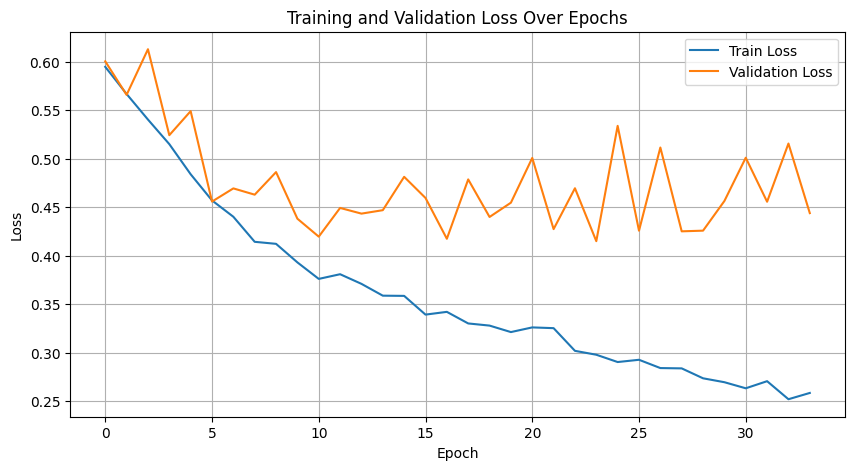

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def compute_metrics(preds, targets):
    preds = preds.view(-1)
    targets = targets.view(-1)

    tp = (preds * targets).sum()  # True positives
    tn = ((1 - preds) * (1 - targets)).sum()  # True negatives
    fp = (preds * (1 - targets)).sum()  # False positives
    fn = ((1 - preds) * targets).sum()  # False negatives

    eps = 1e-7  # to avoid division by zero

    accuracy = (tp + tn) / (tp + tn + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    iou = tp / (tp + fp + fn + eps)

    return {
        'Accuracy': accuracy.item(),
        'Precision': precision.item(),
        'Recall': recall.item(),
        'F1': f1.item(),
        'IoU': iou.item()
    }


In [ ]:
total_metrics = {'Accuracy': 0, 'Precision': 0, 'Recall': 0, 'F1': 0, 'IoU': 0}
num_batches = 0

val_model = UNet(3, 1).to(device)
val_model.load_state_dict(torch.load(os.path.join(save_dir, "model_epoch_30.pth")))

val_model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = val_model(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        metrics = compute_metrics(preds, masks)
        for k in total_metrics:
            total_metrics[k] += metrics[k]
        num_batches += 1

avg_metrics = {k: v / num_batches for k, v in total_metrics.items()}
print(f"Validation Metrics: {avg_metrics}")


Validation Metrics: {'Accuracy': 0.8198997229337692, 'Precision': 0.7904251515865326, 'Recall': 0.8124802559614182, 'F1': 0.7948595136404037, 'IoU': 0.677007257938385}


In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

image = Image.open('sc.jpg').convert('RGB')
img_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
  outputs = val_model(img_tensor)
  pred = torch.sigmoid(outputs)

mask = pred.squeeze().cpu().numpy()
mask = (mask > 0.5).astype(np.uint8) * 255

ret, thresh = cv2.threshold(mask, 150, 255, cv2.THRESH_BINARY)

cv2.imwrite('sc.png', thresh)

True

In [ ]:
import numpy as np
import cv2
from PIL import Image
from torchvision import transforms

def extract_segments(image_pil, mask_pil, min_area=300, output_size=(256, 256)):
    """
    Extracts and returns segmented object crops from a PIL image based on its binary mask.

    Args:
        image_pil (PIL.Image): Original image.
        mask_pil (PIL.Image): Binary segmentation mask (grayscale).
        min_area (int): Minimum area to keep a segment.
        output_size (tuple): Output size (H, W) for each segment.

    Returns:
        List[PIL.Image]: List of cropped, resized segments as PIL images.
    """
    # Transform (resize)
    resize_transform = transforms.Resize(output_size)

    # Convert images to numpy arrays
    image_np = np.array(resize_transform(image_pil))
    mask_np = (np.array(mask_pil) > 0).astype(np.uint8)

    # Get connected components
    num_labels, labels = cv2.connectedComponents(mask_np)

    segments = []

    for label_id in range(1, num_labels):
        object_mask = (labels == label_id).astype(np.uint8) * 255
        contours, _ = cv2.findContours(object_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for cont in contours:
            if cv2.contourArea(cont) < min_area:
                continue

            x, y, w, h = cv2.boundingRect(cont)
            cropped = image_np[y:y+h, x:x+w]

            # Convert to PIL and resize
            pil_crop = Image.fromarray(cropped)
            resized_crop = resize_transform(pil_crop)
            segments.append(resized_crop)

    return segments


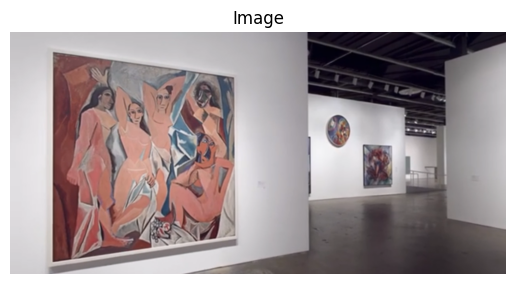

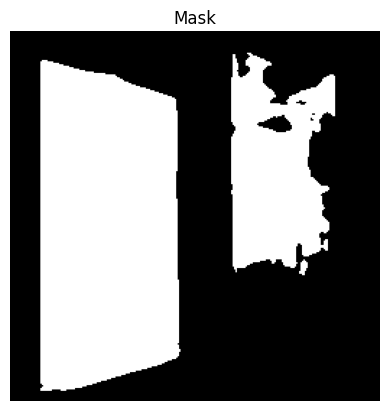

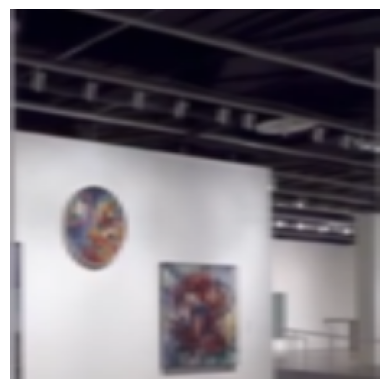

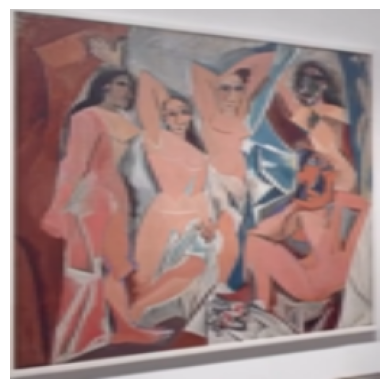

In [ ]:
image = Image.open("sc.jpg")
plt.imshow(image)
plt.title("Image")
plt.axis('off')
plt.show()
mask = Image.open("sc.png")
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.axis('off')
plt.show()

segments = extract_segments(image, mask)

for segment in segments:
    plt.imshow(segment)
    plt.axis('off')
    plt.show()
